# <h1 style="text-align: center;">Identifying Top Films 

#### -Importing relevant libraries

In [79]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import sqlite3
from sqlalchemy import create_engine
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)
sns.set(style="whitegrid", rc={"figure.dpi":100})

#### Loading the database

In [80]:
budgets = pd.read_csv("../Data/tn.movie_budgets.csv", low_memory=False)
tmdb = pd.read_csv("../Data/tmdb.movies.csv", low_memory=False)
bom = pd.read_csv('../Data/bom.movie_gross.csv', low_memory=False)

In [81]:
#check columns
print(budgets.columns)
print(tmdb.columns)
print(bom.columns)

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')
Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')
Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')


#### Loading the `im.db` sqlite database

In [82]:
#connect to the database
conn = sqlite3.connect("../Data/im.db")
tables= pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print( "Tables in im.db:")
print(tables)
tables.columns = ['name']

Tables in im.db:
            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


In [83]:
movie_basics = pd.read_sql_query("SELECT * FROM movie_basics;", conn)
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings;", conn)

## Data cleaning

### 1. `tbmd.movies.csv` read as `tmbd`

In [84]:
tmdb.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [85]:
print(tmdb.info())
print(tmdb.isnull().sum())
tmdb.dropna(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB
None
Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64


## Steps:
Ensure `release_date` is datetime and extract the year.

Clean the `title` column (lowercase, trimmed).

Missing values.

Keep only relevant columns for analysis.

In [86]:
#converting data types to datetime
tmdb['release_date'] = pd.to_datetime(tmdb['release_date'],errors='coerce')
 
 #extracting year from release_date
tmdb['release_year'] = tmdb['release_date'].dt.year

#clean title 
tmdb['title_clean'] = tmdb['title'].str.lower().str.strip()

#Drop duplicates
tmdb.drop_duplicates(subset=['title_clean','release_year'], keep='first', inplace=True)

#drop unnamed
tmdb.drop(columns=['Unnamed: 0'],inplace=True)

#missing values to clean 
tmdb.isnull().sum()


genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
release_year         0
title_clean          0
dtype: int64

In [87]:
tmdb.duplicated().sum()

np.int64(0)

In [88]:
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_year,title_clean
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,2010,harry potter and the deathly hallows: part 1
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,2010,how to train your dragon
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,2010,iron man 2
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,1995,toy story
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,2010,inception


### 2. `bom.movie_gross.csv` read as `bom`

In [89]:
bom.head(20)


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
5,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010
6,Iron Man 2,Par.,312400000.0,311500000,2010
7,Tangled,BV,200800000.0,391000000,2010
8,Despicable Me,Uni.,251500000.0,291600000,2010
9,How to Train Your Dragon,P/DW,217600000.0,277300000,2010


In [90]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [91]:
#converting the foreign gross to numeric
bom['foreign_gross'] = pd.to_numeric(bom['foreign_gross'], errors='coerce') 

#drop missing row domestic_gross
bom.dropna(subset=['domestic_gross'], inplace=True)

#fill missing studio with 'unknown'
bom['studio'].fillna('unknown', inplace=True)

#changing data type to datetime
bom['year'] = pd.to_datetime(bom['year'])

# Fill missing foreign_gross with median (preserve 70%+)
median_foreign = bom['foreign_gross'].median()
bom['foreign_gross'].fillna(median_foreign, inplace=True)

#add total_gross column
bom['total_gross']=bom['domestic_gross']+bom['foreign_gross']


C:\Users\HP\AppData\Local\Temp\ipykernel_22336\3316764610.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bom['studio'].fillna('unknown', inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_22336\3316764610.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

In [92]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3359 entries, 0 to 3386
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           3359 non-null   object        
 1   studio          3359 non-null   object        
 2   domestic_gross  3359 non-null   float64       
 3   foreign_gross   3359 non-null   float64       
 4   year            3359 non-null   datetime64[ns]
 5   total_gross     3359 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 183.7+ KB


### 3. `tn.movie_budget.csv` read as `budgets`

In [93]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [94]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


Remove `$` and `,` from the columns and convert to type Int64

Ensure `release_date` is datetime and extract the release_year.

Clean the `movie` column (lowercase, trimmed).

 generate the `profit`  column (`worldwide_gross`-`production_budget`)

In [95]:
# Remove dollar signs and commas
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    budgets[col] = (
        budgets[col]
        .replace('[\$,]', '', regex=True)
        .astype(float)
    )
# Convert release_date to datetime
budgets['release_date'] = pd.to_datetime(budgets['release_date'], errors='coerce')

# Extract release year
budgets['release_year'] = budgets['release_date'].dt.year

# Clean movie title (lowercase, strip spaces)
budgets['movie_clean'] = budgets['movie'].str.lower().str.strip()

# Generate a `profit` column to determine net earnings by subtracting production costs from total revenues.
budgets['profit'] = budgets['worldwide_gross'] - budgets['production_budget']

# Profit ratio for The Numbers data
budgets['profit_ratio'] = budgets['worldwide_gross'] / budgets['production_budget']
budgets['profit_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Cap extreme outliers (values above 20 are rare in film data)
budgets['profit_ratio'] = budgets['profit_ratio'].clip(upper=20)

C:\Users\HP\AppData\Local\Temp\ipykernel_22336\151691194.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  budgets['profit_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)


### 4. `im.db` database 

In [96]:
#merging movie_basics and movie_ratings on movie_id
movie_basics_ratings= pd.read_sql('''SELECT *
               FROM movie_basics 
               JOIN movie_ratings 
               USING(movie_id);
            ''', conn)


In [97]:
movie_basics_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [98]:
movie_basics_ratings['title_clean'] = movie_basics_ratings['primary_title'].str.lower().str.strip()
movie_basics_ratings['year'] = pd.to_datetime(movie_basics_ratings['start_year'], errors='coerce')

In [99]:
movie_basics_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   movie_id         73856 non-null  object        
 1   primary_title    73856 non-null  object        
 2   original_title   73856 non-null  object        
 3   start_year       73856 non-null  int64         
 4   runtime_minutes  66236 non-null  float64       
 5   genres           73052 non-null  object        
 6   averagerating    73856 non-null  float64       
 7   numvotes         73856 non-null  int64         
 8   title_clean      73856 non-null  object        
 9   year             73856 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 5.6+ MB


In [100]:
#drop runtime_minutes
movie_basics_ratings = movie_basics_ratings.dropna(subset=['runtime_minutes'])

#fill missing genres with unknown to preserve data
movie_basics_ratings['genres']=movie_basics_ratings['genres'].fillna('Unknown')

#check again percentage of missing values
(movie_basics_ratings.isna().sum() / len(movie_basics_ratings) * 100).sort_values(ascending=False)

movie_id           0.0
primary_title      0.0
original_title     0.0
start_year         0.0
runtime_minutes    0.0
genres             0.0
averagerating      0.0
numvotes           0.0
title_clean        0.0
year               0.0
dtype: float64

## Data Preparation and Transformation

In [101]:
#checking  columns for easy Process
print(budgets.columns)
print(bom.columns)
print(tmdb.columns)
print(movie_basics_ratings.columns)

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'release_year', 'movie_clean', 'profit',
       'profit_ratio'],
      dtype='object')
Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year',
       'total_gross'],
      dtype='object')
Index(['genre_ids', 'id', 'original_language', 'original_title', 'popularity',
       'release_date', 'title', 'vote_average', 'vote_count', 'release_year',
       'title_clean'],
      dtype='object')
Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'title_clean',
       'year'],
      dtype='object')


In [102]:
#merge datasets budgets and bom
data_box = pd.merge(budgets, bom,
                  left_on='movie',
                  right_on='title',
                  how='inner')

print(f"Budget and box office datasets merged successfully!")
print(f"Shape: {data_box.shape}")
print(f"\nFirst rows of the data:")
data_box.head()

Budget and box office datasets merged successfully!
Shape: (1245, 16)

First rows of the data:


,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,release_year,movie_clean,profit,profit_ratio,title,studio,domestic_gross_y,foreign_gross,year,total_gross
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,pirates of the caribbean: on stranger tides,6.350639e+08,2.546673,Pirates of the Caribbean: On Stranger Tides,BV,241100000.0,804600000.0,1970-01-01 00:00:00.000002011,1.045700e+09
1,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,avengers: age of ultron,1.072414e+09,4.243841,Avengers: Age of Ultron,BV,459000000.0,946400000.0,1970-01-01 00:00:00.000002015,1.405400e+09
2,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,2018,avengers: infinity war,1.748134e+09,6.827114,Avengers: Infinity War,BV,678800000.0,19550000.0,1970-01-01 00:00:00.000002018,6.983500e+08
3,9,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,2017,justice league,3.559452e+08,2.186484,Justice League,WB,229000000.0,428900000.0,1970-01-01 00:00:00.000002017,6.579000e+08
4,10,2015-11-06,Spectre,300000000.0,200074175.0,8.796209e+08,2015,spectre,5.796209e+08,2.932070,Spectre,Sony,200100000.0,680600000.0,1970-01-01 00:00:00.000002015,8.807000e+08


In [103]:
# merging the  datasets movie_basics_ratings and budgets
combined_data_with_budget = pd.merge(movie_basics_ratings,budgets, how="inner", left_on="primary_title", right_on="movie")
combined_data_with_budget.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean,year,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,movie_clean,profit,profit_ratio
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,foodfight!,1970-01-01 00:00:00.000002012,26,2012-12-31,Foodfight!,45000000.0,0.0,73706.0,2012,foodfight!,-44926294.0,0.001638
1,tt0326592,The Overnight,The Overnight,2010,88.0,Unknown,7.5,24,the overnight,1970-01-01 00:00:00.000002010,21,2015-06-19,The Overnight,200000.0,1109808.0,1165996.0,2015,the overnight,965996.0,5.829980
2,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,on the road,1970-01-01 00:00:00.000002012,17,2013-03-22,On the Road,25000000.0,720828.0,9313302.0,2013,on the road,-15686698.0,0.372532
3,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,the secret life of walter mitty,1970-01-01 00:00:00.000002013,37,2013-12-25,The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0,2013,the secret life of walter mitty,96861183.0,2.064409
4,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,a walk among the tombstones,1970-01-01 00:00:00.000002014,67,2014-09-19,A Walk Among the Tombstones,28000000.0,26017685.0,62108587.0,2014,a walk among the tombstones,34108587.0,2.218164


In [104]:
# Drop duplicates and keep first occurrence
combined_data_with_budget = combined_data_with_budget.drop_duplicates(subset=['release_date', 
                                                                              'movie',
                                                                              'domestic_gross',
                                                                              'production_budget',
                                                                              'worldwide_gross'], keep='first')

# confirm duplicates have been dropped.
combined_data_with_budget.duplicated().sum()

np.int64(0)

In [105]:
# We noticed from data exploration that the genre col had a few missing values . So drop missing values
combined_data_with_budget.dropna(inplace= True)

In [106]:
combined_data_with_budget.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2150 entries, 0 to 2740
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2150 non-null   object        
 1   primary_title      2150 non-null   object        
 2   original_title     2150 non-null   object        
 3   start_year         2150 non-null   int64         
 4   runtime_minutes    2150 non-null   float64       
 5   genres             2150 non-null   object        
 6   averagerating      2150 non-null   float64       
 7   numvotes           2150 non-null   int64         
 8   title_clean        2150 non-null   object        
 9   year               2150 non-null   datetime64[ns]
 10  id                 2150 non-null   int64         
 11  release_date       2150 non-null   datetime64[ns]
 12  movie              2150 non-null   object        
 13  production_budget  2150 non-null   float64       
 14  domestic_gros

In [107]:
# Top grossing movies
top_movies = bom.sort_values('total_gross', ascending=False).head(5)
print(top_movies[['title', 'studio', 'total_gross']])
 
print('--------------------------------------------------------------------------------')
# Total gross per studio
studio_gross = bom.groupby('studio')['total_gross'].sum().sort_values(ascending=False)
print(studio_gross)

                                            title studio   total_gross
727                         Marvel's The Avengers     BV  1.518900e+09
1875                      Avengers: Age of Ultron     BV  1.405400e+09
3080                                Black Panther     BV  1.347000e+09
328   Harry Potter and the Deathly Hallows Part 2     WB  1.341500e+09
2758                     Star Wars: The Last Jedi     BV  1.332600e+09
--------------------------------------------------------------------------------
studio
BV              4.429108e+10
Fox             3.104447e+10
WB              3.103145e+10
Uni.            2.987446e+10
Sony            2.248312e+10
                    ...     
FOAK            1.243000e+05
IVP             1.121000e+05
Darin Southa    9.840000e+04
ITL             5.290000e+04
WOW             4.940000e+04
Name: total_gross, Length: 256, dtype: float64


In [108]:
import re

def normalize_title(title):
    if pd.isna(title):
        return ''
    t = str(title).lower()
    t = re.sub(r'\(.*?\)', '', t)     # remove text in parentheses
    t = re.sub(r'[^a-z0-9\s]', '', t) # remove punctuation
    t = re.sub(r'\s+', ' ', t).strip()
    return t

# Apply normalization across datasets
movie_basics['title_norm'] = movie_basics['primary_title'].apply(normalize_title)
bom['title_norm'] = bom['title'].apply(normalize_title)
tmdb['title_norm'] = tmdb['title'].apply(normalize_title)
budgets['title_norm'] = budgets['movie'].apply(normalize_title)


# Visualizations

# Profit Distribution

In [109]:
data_box.columns
data_box['profit_ratio'].dropna()

0        2.546673
1        4.243841
2        6.827114
3        2.186484
4        2.932070
          ...    
1240     3.181096
1241    20.000000
1242    20.000000
1243    20.000000
1244     8.482980
Name: profit_ratio, Length: 1245, dtype: float64

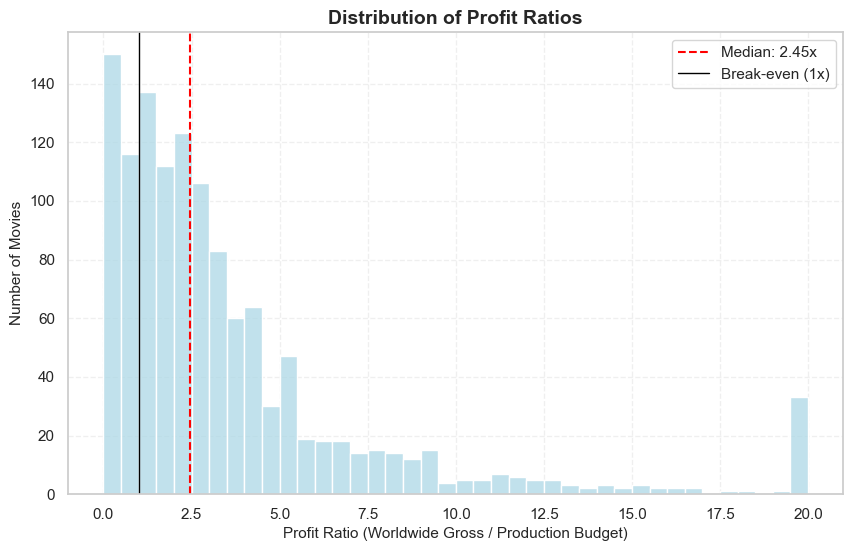

In [111]:
plt.figure(figsize=(10, 6))
sns.histplot(data_box['profit_ratio'], bins=40, color='lightblue')
plt.title('Distribution of Profit Ratios', fontsize=14, fontweight='bold')
plt.xlabel('Profit Ratio (Worldwide Gross / Production Budget)', fontsize=11)
plt.ylabel('Number of Movies', fontsize=11)
plt.axvline(data_box['profit_ratio'].median(), color='red', linestyle='--', 
            label=f'Median: {data_box["profit_ratio"].median():.2f}x')
plt.axvline(1, color='black', linestyle='-', linewidth=1, label='Break-even (1x)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


## Top 10 Studios by Average profit

C:\Users\HP\AppData\Local\Temp\ipykernel_22336\2790338702.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_studios.values, y=top_studios.index, palette='viridis')


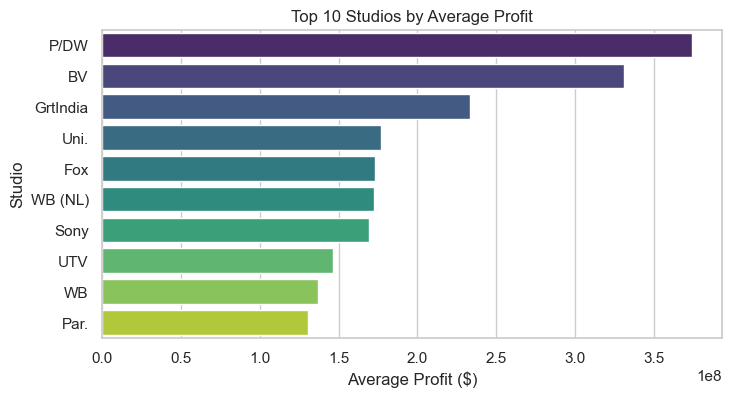

In [112]:
# compute total profit
data_box['profit'] = data_box['worldwide_gross'] - data_box['production_budget']

top_studios = data_box.groupby('studio')['profit'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_studios.values, y=top_studios.index, palette='viridis')

plt.title('Top 10 Studios by Average Profit')
plt.xlabel('Average Profit ($)')
plt.ylabel('Studio')
plt.show()

## Profit Distribution in top 5 studios

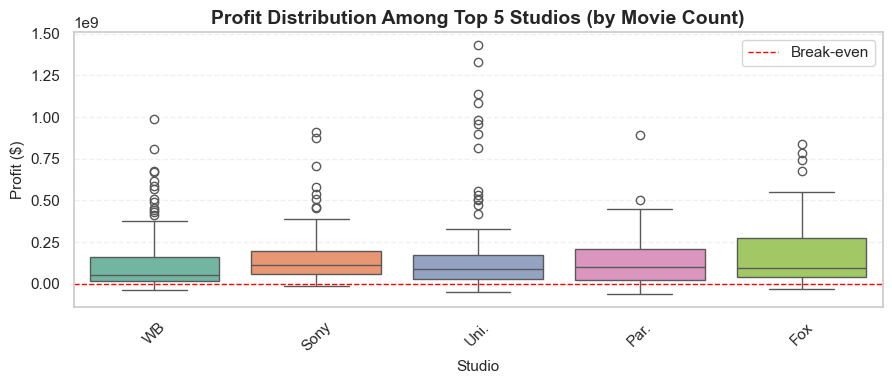

In [114]:
top5_studios = data_box['studio'].value_counts().head(5).index

plt.figure(figsize=(9, 4))
sns.boxplot(
    x='studio',
    y='profit',
    hue='studio',   # <-- Add this
    data=data_box[data_box['studio'].isin(top5_studios)],
    palette='Set2',
    legend=False    # <-- Hide the duplicate legend
)

plt.title('Profit Distribution Among Top 5 Studios (by Movie Count)', fontsize=14, fontweight='bold')
plt.xlabel('Studio', fontsize=11)
plt.ylabel('Profit ($)', fontsize=11)
plt.xticks(rotation=45)
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Break-even')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

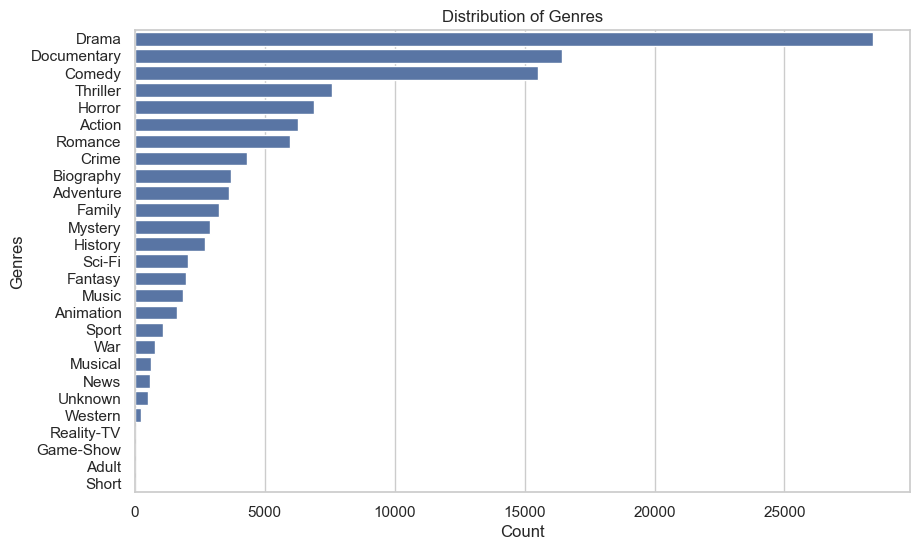

In [116]:
# Distribution of genres in our dataset
plt.figure(figsize=(10, 6))
movie_basics_and_rating_exploded = movie_basics_ratings['genres'].str.split(',').explode()
sns.countplot(y=movie_basics_and_rating_exploded, order=movie_basics_and_rating_exploded.value_counts().index)
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_22336\1062651926.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='averagerating', y='genres', data=genre_avg_rating, palette='viridis')


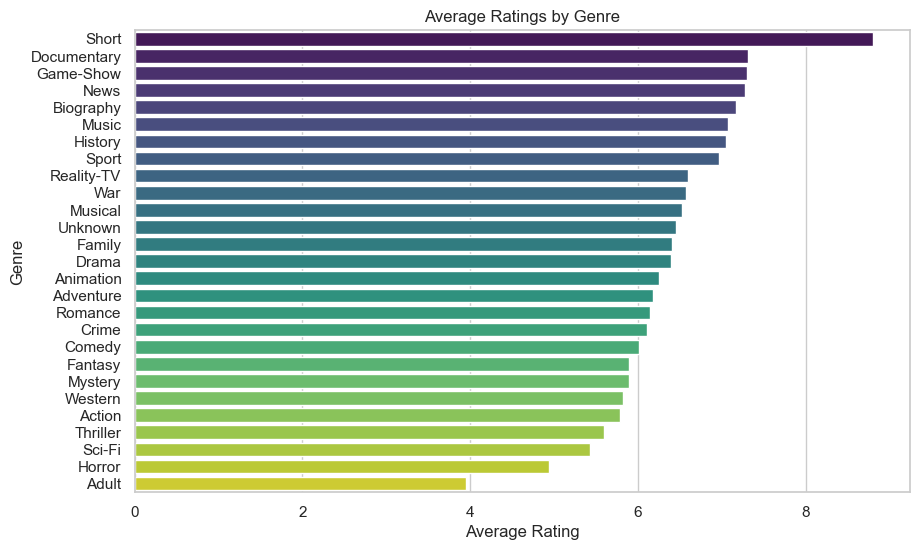

In [117]:
# Exploding genres to handle multiple genres per movie
movie_basics_ratings_exploded = movie_basics_ratings.assign(genres=movie_basics_ratings['genres'].str.split(',')).explode('genres')

# Calculating the average rating for each genre
genre_avg_rating = movie_basics_ratings_exploded.groupby('genres')['averagerating'].mean().reset_index().sort_values(by = 'averagerating', ascending=False)


# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='averagerating', y='genres', data=genre_avg_rating, palette='viridis')
plt.title('Average Ratings by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

# top genres by average rating

C:\Users\HP\AppData\Local\Temp\ipykernel_22336\3309913576.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_ratings.values, y=genre_ratings.index, palette='rocket')


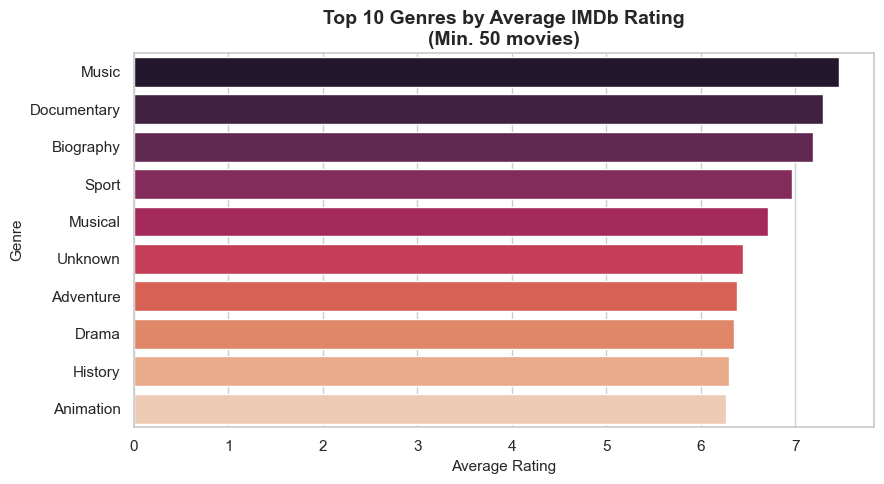

In [118]:
# Extract primary genre (first genre listed)
movie_basics_ratings['primary_genre'] = movie_basics_ratings['genres'].apply(lambda x: x.split(',')[0] if pd.notna(x) else 'Unknown')

# Filter genres with at least 50 movies
genre_counts = movie_basics_ratings['primary_genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 50].index

genre_ratings = movie_basics_ratings[movie_basics_ratings['primary_genre'].isin(valid_genres)].groupby('primary_genre')['averagerating'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(9, 5))
sns.barplot(x=genre_ratings.values, y=genre_ratings.index, palette='rocket')
plt.title('Top 10 Genres by Average IMDb Rating\n(Min. 50 movies)', fontsize=14, fontweight='bold')
plt.xlabel('Average Rating', fontsize=11)
plt.ylabel('Genre', fontsize=11)
plt.tight_layout()
plt.show()

# What movies genres have been the most successful financially?
To answer this question, we look at the box office gross earnings and profits of various movies.

In [119]:
# check the top perfoming movies
top_20_movies_world=budgets.nlargest (n=20, columns='worldwide_gross')
top_20_movies_domestic = budgets.nlargest(n=20, columns ='domestic_gross')